# Training with Learning Rate Scheduler

In [1]:
from glob import glob

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt
%matplotlib inline

## Hyperparameter Tunning

In [2]:
num_epochs = 20
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [3]:
inputs = layers.Input(input_shape)
net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [4]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

# Data Preprocess

In [5]:
# Learning Rate을 빨리 보기 위해서 데이타를 줄임
train_paths = glob('../dataset/cifar/train/*.png')[:1000]
test_paths = glob('../dataset/cifar/test/*.png')[:1000]

In [6]:
path = train_paths[0]
path

'../dataset/cifar/train\\0_frog.png'

In [7]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

In [8]:
train_labels = [get_class_name(path) for path in train_paths]

In [9]:
class_names = np.unique(train_labels)
class_names

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

In [10]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return onehot

In [11]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.  # rescale
    label = get_label(path)
    return image, label

In [12]:
path

'../dataset/cifar/train\\0_frog.png'

In [13]:
image, label = load_image_label(path)

In [14]:
np.min(image), np.max(image)

(0.0, 1.0)

In [15]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [16]:
image_preprocessed, label = image_preprocess(image, label)

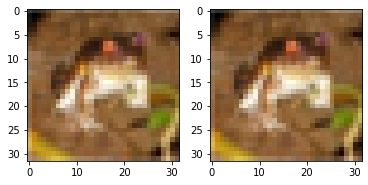

In [17]:
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(image_preprocessed)
plt.show()

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [20]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

# Learning Rate Scheduler

In [21]:
import math

In [22]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * math.exp(0.1 * (10 - epoch))

# verbose 사용시 Learning Rate 변활를 볼 수 있음
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

## Training

In [23]:
len(train_paths) // batch_size

3

In [24]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

steps_per_epoch, validation_steps

(3, 3)

In [25]:
image, label = next(iter(train_dataset))

In [26]:
image.shape, label.shape

(TensorShape([32, 32, 32, 3]), TensorShape([32, 10]))

In [27]:
# 11 epoch이후 부터 learning rate 변화됨을 확인할 수 있음
model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs,
    callbacks=[learning_rate_scheduler]
)

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/20
3/3 [==============================] - 1s 319ms/step - loss: 2.3142 - accuracy: 0.1029 - val_loss: 2.3060 - val_accuracy: 0.1771

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/20
3/3 [==============================] - 1s 253ms/step - loss: 2.2485 - accuracy: 0.2083 - val_loss: 2.3359 - val_accuracy: 0.0729

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/20
3/3 [==============================] - 1s 247ms/step - loss: 2.3287 - accuracy: 0.1176 - val_loss: 2.3291 - val_accuracy: 0.0729

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/20
3/3 [==============================] - 1s 186ms/step - loss: 2.3045 - accuracy: 0.1618 - val_loss: 2.3269 - val_accuracy: 0.0729

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
Epoch 5/20
3/3 [===